In [1]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(BSgenome.Hsapiens.UCSC.hg38)
library(EnsDb.Hsapiens.v86)
library(BSgenome.Mmusculus.UCSC.mm10)
library(EnsDb.Mmusculus.v79)
library(ggplot2)
library(patchwork)
library(Matrix)
library(GenomicRanges)
library(tidyverse)
set.seed(1234)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following obj

In [2]:
#
LoadData <- function(data_path=NULL, assay='ATAC'){
    if (assay=='ATAC'){
        atac_assay=readMM(paste0(data_path,'/matrix.mtx'))
        barcodes=readLines(paste0(data_path,'/barcodes.tsv'))
        peaks=readLines(paste0(data_path,'/peak.bed'))
        row.names(atac_assay)=peaks
        colnames(atac_assay)=barcodes
        #
        return (atac_assay)
    }
    if (assay=='RNA'){
        rna_assay=readMM(paste0(data_path,'/matrix.mtx'))
        barcodes=readLines(paste0(data_path,'/barcodes.tsv'))
        features=readLines(paste0(data_path,'/genes.tsv'))
        row.names(rna_assay)=features
        colnames(rna_assay)=barcodes
        #
        return (rna_assay)
    }
    if (assay=='GeneScore'){
        rna_assay=readMM(paste0(data_path,'/matrix.mtx'))
        barcodes=readLines(paste0(data_path,'/barcodes.tsv'))
        features=readLines(paste0(data_path,'/genes.tsv'))
        row.names(rna_assay)=features
        colnames(rna_assay)=barcodes
        #
        return (rna_assay)
    }
}
#
Processing_peaks <- function(peak_file=NULL, sep = c(":", "-"), remove_genome='mm10'){
    # loading
    peaks <- readLines(peak_file)
    
    # processing
    if (remove_genome=='mm10'){
        peaks=peaks[!grepl(paste0(c('mm10'), collapse = "|"), peaks)]
        peaks=gsub('GRCh38_','',peaks)
    }
    if (remove_genome=='hg19'){
        peaks=peaks[!grepl(paste0(c('GRCh38'), collapse = "|"), peaks)]
        peaks=gsub('mm10_','',peaks)
    }
    
    # convert to genomic ranges
    gr.peaks <- StringToGRanges(regions = peaks, sep = sep)
    # standard peaks
    gr.peaks <- Standard_peaks(gr.peaks)
    return (gr.peaks)
}
#
Processing_counts <- function(counts=NULL, remove_genome='mm10'){
    if (remove_genome=='mm10'){
        peaks=row.names(counts)
        peaks=peaks[!grepl(paste0(c('mm10'), collapse = "|"), peaks)]
        counts=counts[peaks,]
        #
        peaks=row.names(counts)
        peaks=gsub('hg19_','',peaks)
        row.names(counts)=peaks
        return (counts)
    }
    ###
    if (remove_genome=='hg19'){
        peaks=row.names(counts)
        peaks=peaks[!grepl(paste0(c('hg19'), collapse = "|"), peaks)]
        counts=counts[peaks,]
        #
        peaks=row.names(counts)
        peaks=gsub('mm10_','',peaks)
        row.names(counts)=peaks
        return (counts)
    }
}
Standard_peaks <- function (rowRanges=rowRanges, annotation='hg38'){
    if (annotation=='hg19'){main.chroms <- standardChromosomes(BSgenome.Hsapiens.UCSC.hg19)}
    if (annotation=='hg38'){main.chroms <- standardChromosomes(BSgenome.Hsapiens.UCSC.hg38)}
    if (annotation=='mm10'){main.chroms <- standardChromosomes(BSgenome.Mmusculus.UCSC.mm10)}
    keep.peaks <- which(as.character(seqnames(rowRanges)) %in% main.chroms)
    #keep.peaks <- which(as.character(seqnames(rowRanges)) %in% c('chr1'))
    rowRanges <- rowRanges[keep.peaks]
    
    #peaks=as.data.frame(rowRanges)[,c(1,2,3)]
    #peaks=peaks[keep.peaks,]
    #rowRanges <- makeGRangesFromDataFrame(peaks)
    
    return (rowRanges)
}
Create_scRNA_object <- function(data.dir=NULL, rna.assay=NULL){
    #
    if (is.null(data.dir)){
        if (is.null(rna.assay)){stop('Please provide the RNA expression matrix')}
    }
    else{
        rna.assay=Read10X(data.dir = data.dir, gene.column = 1)
        #rna.assay=Read10X(data.dir = data.dir, gene.column = 2)
    }
    #
    proj <- CreateSeuratObject(counts = rna.assay)
    #
    return(proj)
}
Create_scATAC_object <- function(counts=NULL,fragment_file=NULL){
    #
    atac.assay <- CreateChromatinAssay(counts, fragments = fragment_file)
    atac.obj <- CreateSeuratObject(atac.assay, assay = "ATAC")
    #
    return (atac.obj)
}
# Do annotation for seurat object
annotate_ATAC_obj <- function(proj=proj, annotation='hg38'){
    #
    if (annotation=='hg38'){
        hg38 = "/path/database/Human/genes.gtf"
        gtf <- rtracklayer::import(hg38)
        gene.coords <- gtf[gtf$type == 'gene']
        seqlevelsStyle(gene.coords) <- 'UCSC'
        gene.coords <- keepStandardChromosomes(gene.coords, pruning.mode = 'coarse')
        gene.coords$gene_biotype <- gene.coords$gene_type
    }
    #
    if (annotation=='mm10'){
        mm10 = "/path/database/Mouse/genes.gtf"
        gtf <- rtracklayer::import(mm10)
        gene.coords <- gtf[gtf$type == 'gene']
        seqlevelsStyle(gene.coords) <- 'UCSC'
        gene.coords <- keepStandardChromosomes(gene.coords, pruning.mode = 'coarse')
        gene.coords$gene_biotype <- gene.coords$gene_type
    }
    # add the gene information to the object
    Annotation(proj) <- gene.coords
    #
    return (proj)
}

# Trackplot

## HEK293T

In [3]:
HEK293T_frag1='./rawdata/fragment/ATAC_CL_IL9.Human.fragments.tsv.gz'
HEK293T_frag2='./rawdata/fragment/ATAC_CL_IL10.Human.fragments.tsv.gz'
data_path='./rawdata/'
name2=c('IL9','IL10')
sample_name2=c('ATAC_CL_IL9_web_3','ATAC_CL_IL10_web_3')
barcode_path2 = c()
peak_path2 = c()
for (i in 1:length(sample_name2)){
    barcode_path2 =c(barcode_path2, paste0(data_path, name2[i],'/', sample_name2[i], '/05.Peak/Peak/Human/barcodes.tsv'))
    peak_path2=c(peak_path2, paste0(data_path, name2[i],'/', sample_name2[i], '/05.Peak/Peak/Human/peak.bed'))
}
fragment_paths = c(HEK293T_frag1, HEK293T_frag2)
barcode_paths = c(barcode_path2)
peak_paths = c(peak_path2)

In [4]:
### create scATAC object ###
# merge peaks of different datasets
peak.list <- lapply(X = peak_path2, FUN = function(x) {
    peak_file=x
    peaks=Processing_peaks(peak_file, remove_genome='mm10')
})
combined.peaks <-  purrr::reduce(peak.list, function(x, y) {GenomicRanges::reduce(x = c(x,y))})

# Filter out bad peaks based on length
peakwidths <- width(combined.peaks)
combined.peaks <- combined.peaks[peakwidths  < 5000 & peakwidths > 100]
combined.peaks
# create scATAC object
seurat.list=c()
for (i in 1:length(peak_path2)){
    seurat.obj=Create_scATAC_object(barcodes_file=barcode_path2[i], fragment_file=fragment_paths[i], peaks=combined.peaks)
    seurat.obj$orig.ident=name2[i]
    seurat.list=c(seurat.list, seurat.obj)
}
merged_seurat <- merge(x = seurat.list[[1]], y = seurat.list[c(1:length(name2))[-1]]) # 整合文库
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
# change to UCSC style since the data was mapped to hg19
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "hg38"
# add the gene information to the object
Annotation(merged_seurat) <- annotations

GRanges object with 74484 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1     180879-181666      *
      [2]     chr1     629597-630552      *
      [3]     chr1     631254-631750      *
      [4]     chr1     632969-633297      *
      [5]     chr1     633767-634908      *
      ...      ...               ...    ...
  [74480]     chrY 11304487-11304703      *
  [74481]     chrY 11332994-11333632      *
  [74482]     chrY 56871460-56871726      *
  [74483]     chrM          150-2790      *
  [74484]     chrM       13960-16595      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

Computing hash

Extracting reads overlapping genomic regions

Computing hash

Extracting reads overlapping genomic regions

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(

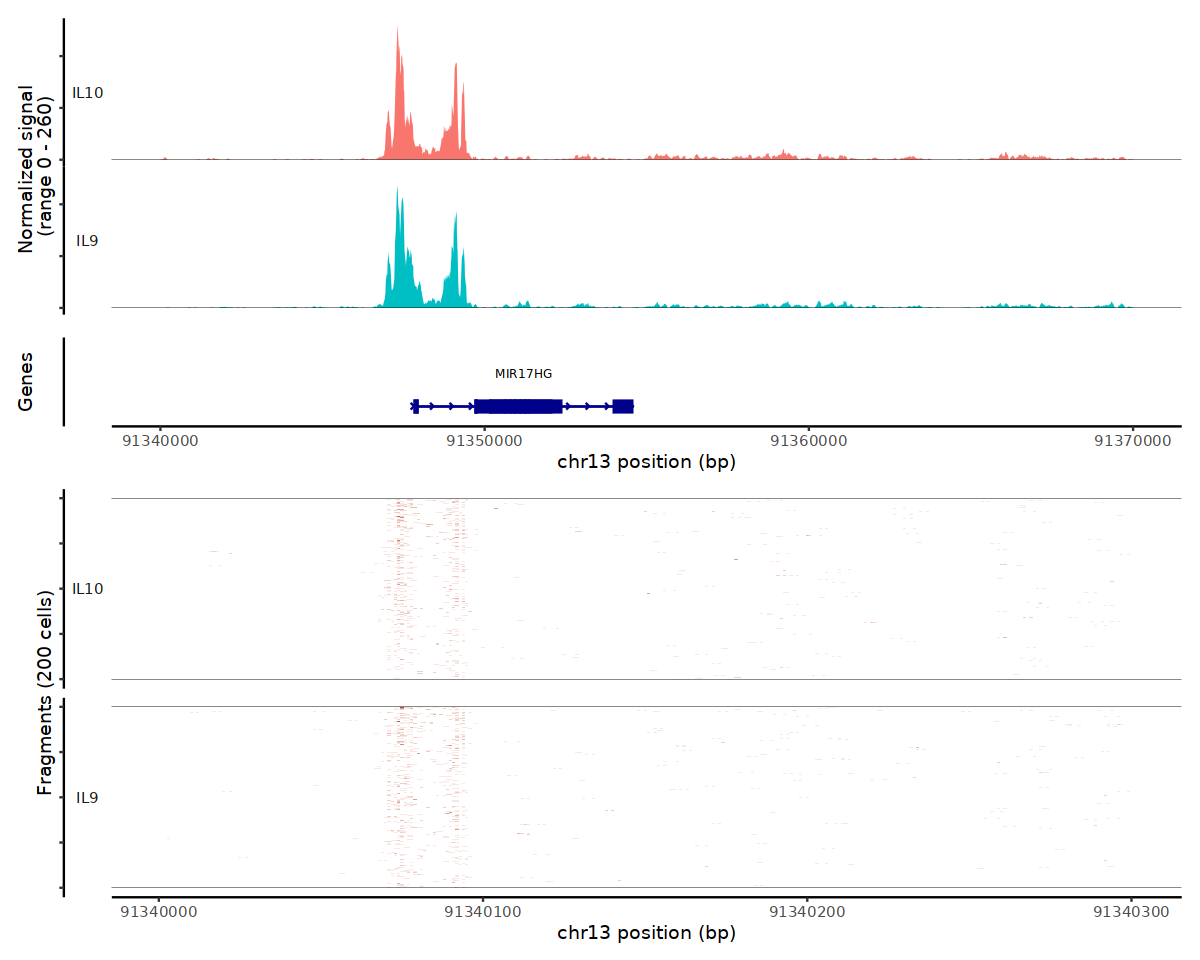

In [5]:
options(repr.plot.width = 10, repr.plot.height = 8)
p1 <- CoveragePlot(object = merged_seurat, group.by = 'orig.ident',region = "chr13-91340000-91370000",annotation = TRUE,peaks = FALSE)
p2 <- TilePlot(object = merged_seurat, group.by = 'orig.ident',tile.cells = 200, region = 'chr13-91340000-91370000',order.by = "top")+ NoLegend()
p1/p2
# ggsave("./01_Cellline/ATAC_NIH293T_trackplot.pdf", p1/p2, width = 10, height = 8, dpi = 600)
# other: chr11-69090000-69130000

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


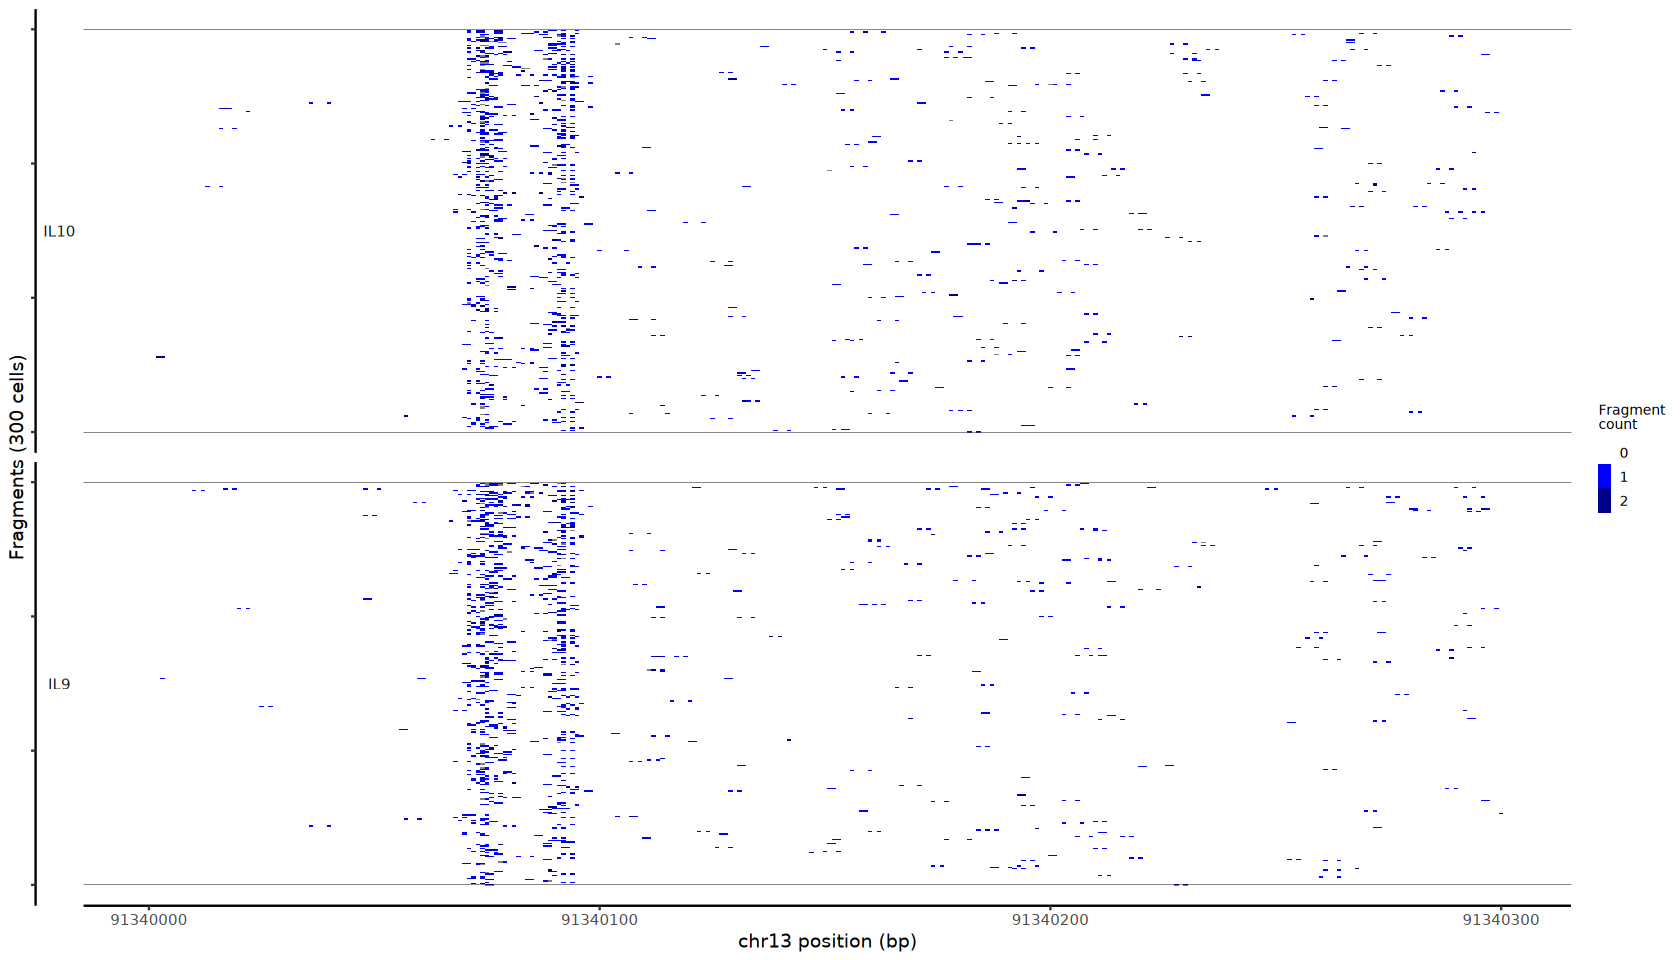

In [6]:
options(repr.plot.width = 14, repr.plot.height = 8)
p1 <-TilePlot(object = merged_seurat, group.by = 'orig.ident',tile.cells = 300, region = 'chr13-91340000-91370000',order.by = "top")+ scale_fill_gradientn(colours=c("white",'blue','darkblue'),limits = c(0,  2),breaks = c(0,1,2))
p1

## NIH3T3

In [7]:
HEK293T_frag4='./rawdata/fragment/ATAC_CL_IL9.Mouse.fragments.tsv.gz'
HEK293T_frag5='./rawdata/fragment/ATAC_CL_IL10.Mouse.fragments.tsv.gz'
fragment_path2 = c(HEK293T_frag4, HEK293T_frag5)
data_path='./rawdata/'
name2=c('IL9','IL10')
sample_name2=c('ATAC_CL_IL9_web_3','ATAC_CL_IL10_web_3')
barcode_path2 = c()
peak_path2 = c()
for (i in 1:length(sample_name2)){
    barcode_path2 =c(barcode_path2, paste0(data_path, name2[i],'/', sample_name2[i], '/05.Peak/Peak/Mouse/barcodes.tsv'))
    peak_path2=c(peak_path2, paste0(data_path, name2[i],'/', sample_name2[i], '/05.Peak/Peak/Mouse/peak.bed'))
}

In [8]:
# merge peaks of different datasets
peak.list <- lapply(X = peak_path2, FUN = function(x) {
    peak_file=x
    peaks=Processing_peaks(peak_file, remove_genome='hg19')
})
combined.peaks <-  purrr::reduce(peak.list, function(x, y) {GenomicRanges::reduce(x = c(x,y))})

# Filter out bad peaks based on length
peakwidths <- width(combined.peaks)
combined.peaks <- combined.peaks[peakwidths  < 5000 & peakwidths > 100]
combined.peaks
# create scATAC object
seurat.list=c()
for (i in 1:length(peak_path2)){
    seurat.obj=Create_scATAC_object(barcodes_file=barcode_path2[i], fragment_file=fragment_path2[i], peaks=combined.peaks)
    seurat.obj$orig.ident=name2[i]
    seurat.list=c(seurat.list, seurat.obj)
}

GRanges object with 83785 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1   3212918-3213182      *
      [2]     chr1   3493745-3494028      *
      [3]     chr1   3514734-3515303      *
      [4]     chr1   3936109-3936398      *
      [5]     chr1   4471056-4471256      *
      ...      ...               ...    ...
  [83781]     chrY 90808766-90808990      *
  [83782]     chrY 90812879-90813098      *
  [83783]     chrM          147-1490      *
  [83784]     chrM         1699-4841      *
  [83785]     chrM         5369-6434      *
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

Computing hash

Extracting reads overlapping genomic regions

Computing hash

Extracting reads overlapping genomic regions



In [9]:
for (i in 1:length(fragment_paths)){
    # add the gene information to the object
    seurat.list[[i]]=annotate_ATAC_obj(seurat.list[[i]], annotation='mm10')
    # add QC info
    #seurat.list[[i]] <- QC_ATAC(seurat.list[[i]], fragment_file = fragment_paths[i], genome = "mm10")
}
merged_seurat <- merge(x = seurat.list[[1]], y = seurat.list[c(1:length(name2))[-1]])
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)
# change to UCSC style since the data was mapped to mm10
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "mm10"
# add the gene information to the object
Annotation(merged_seurat) <- annotations

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

Warning message:
"Removed 48 rows containing missing values or values outside the scale range (`geom_segment()`)."
Warning message:
"Removed 48 rows containing missing values or values outside the scale range (`geom_segment()`)."


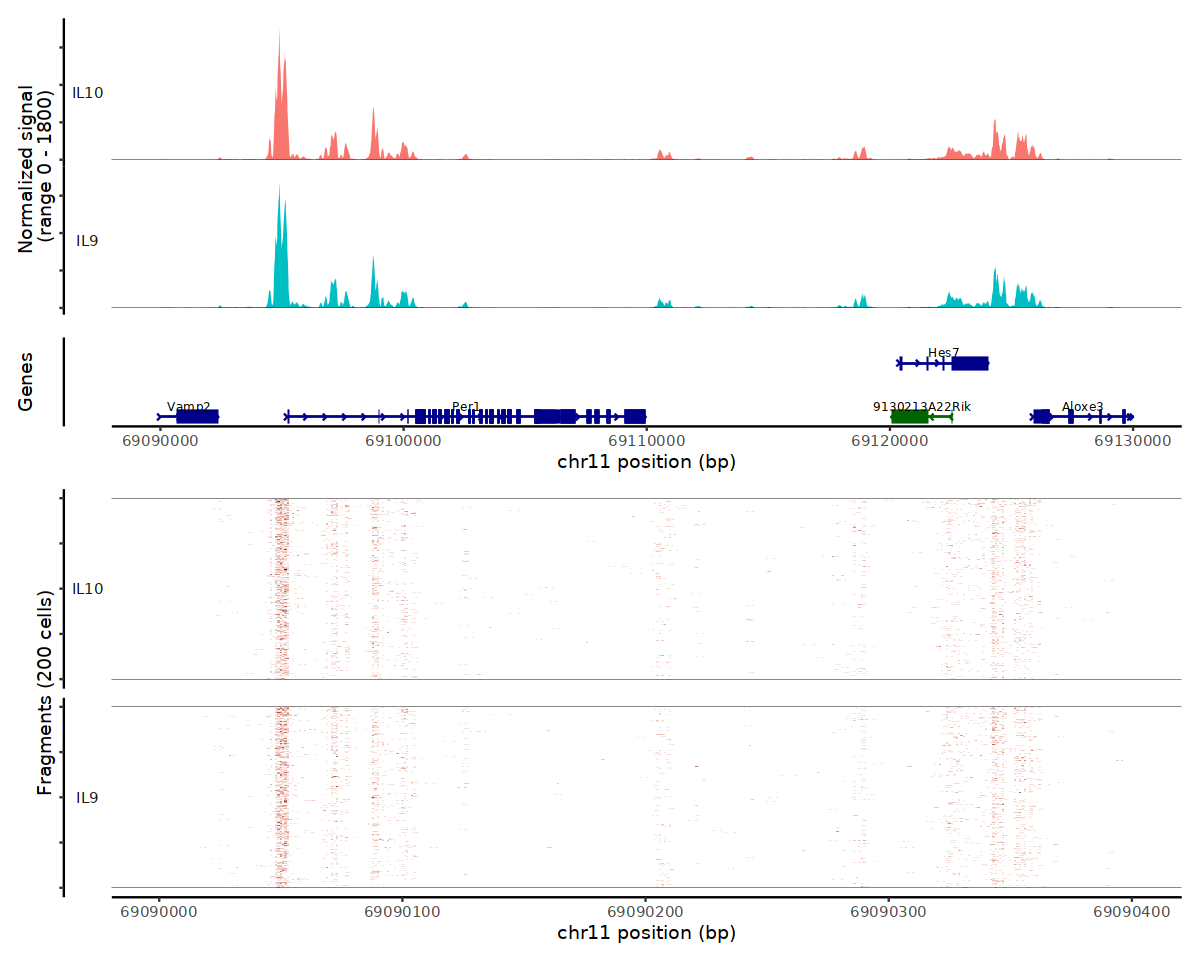

In [10]:
options(repr.plot.width = 10, repr.plot.height = 8)
p1 <- CoveragePlot(object = merged_seurat, group.by = 'orig.ident',region = "chr11-69090000-69130000",annotation = TRUE,peaks = FALSE)
p2 <- TilePlot(object = merged_seurat, group.by = 'orig.ident', tile.cells = 200, region = 'chr11-69090000-69130000',order.by = "top") + NoLegend()
p1/p2
# ggsave("./01_Cellline/ATAC_NIH3T3_trackplot.pdf", p1/p2, width = 10, height = 8, dpi = 600)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


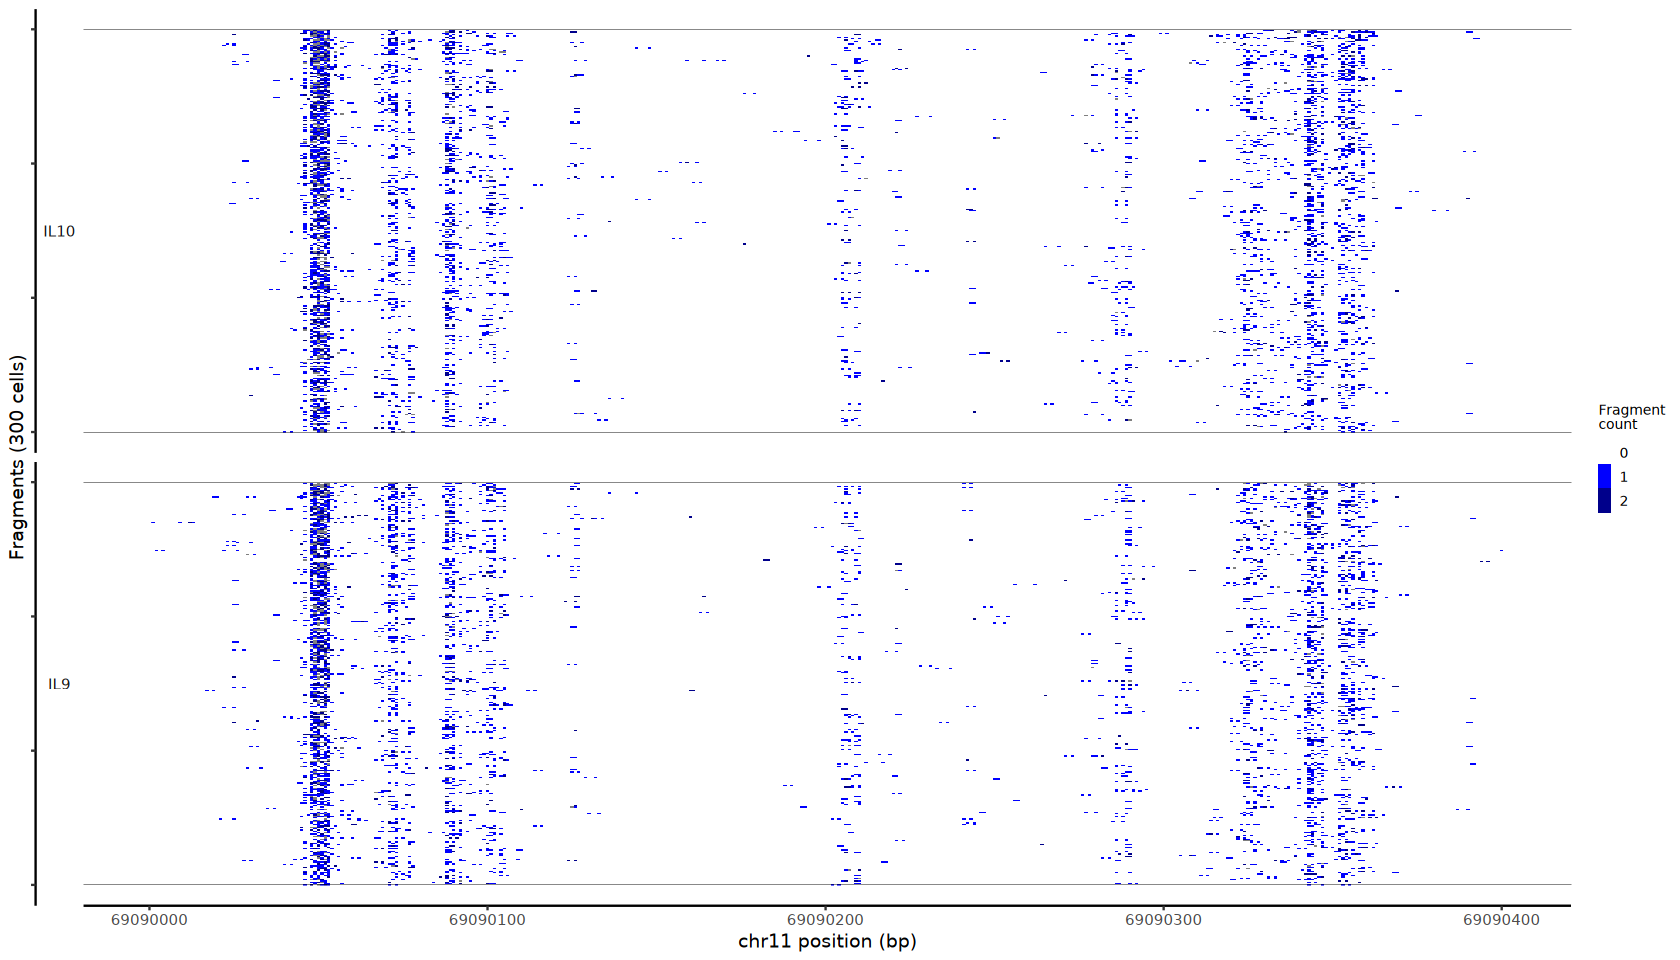

In [11]:
options(repr.plot.width = 14, repr.plot.height = 8)
p2 <-TilePlot(object = merged_seurat, group.by = 'orig.ident',tile.cells = 300, region = 'chr11-69090000-69130000',order.by = "top")+ scale_fill_gradientn(colours=c("white",'blue','darkblue'),limits = c(0, 2),breaks = c(0,1,2))
p2